# Predicting tags from images 

In this notebook, I use product features extracted by feeding products images into a pre-trained VGG16 CNN from Keras Applications to train a feed forward net to predict every label in the articles.csv file.
<br>

The model is built using sklearn wrapper for keras and saved in h5 format in output folder.

All results and trained models are saved in pickle files as dictionaries with keys lableing the target variable and the trained model.
<br>

You can set the target variable to choose which feature to predict.

In [25]:
import numpy as np
import pandas as pd
import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = False
warnings.filterwarnings('ignore')

In [26]:
f = open('../input/hm-articlecustomer-embeddings-from-images/article_embeddings_from_image.pickle', 'rb')
embeds = pickle.load(f)
embeds = pd.DataFrame(embeds).reset_index()
embeds.columns = ['article_id', 'embeds']
embeds.embeds = embeds.embeds.map(np.array)

In [27]:
embeds.head()

,article_id,embeds
0,0108775015,"[3.291787e-07, 1.2355815e-07, 2.049226e-05, 2...."
1,0108775044,"[5.4576713e-06, 3.4250597e-06, 4.4838875e-05, ..."
2,0108775051,"[1.43880325e-05, 2.0696747e-05, 5.7651476e-05,..."
3,0110065001,"[5.4223683e-12, 1.2656559e-11, 3.8108565e-09, ..."
4,0110065002,"[1.0652034e-06, 2.2579894e-05, 0.00044278972, ..."


In [28]:
df = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv', dtype={'article_id':str})
df = df.select_dtypes(object)
df = df.drop(['index_code', 'detail_desc', 'prod_name'], axis=1)

# drop_mask = df.product_type_name.value_counts() > 5
# to_keep = drop_mask[drop_mask == True].index
# df = df[df.product_type_name.isin(to_keep)]

In [29]:
df = df.merge(embeds, on='article_id')

In [30]:
df.head()

,article_id,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,embeds
0,0108775015,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[3.291787e-07, 1.2355815e-07, 2.049226e-05, 2...."
1,0108775044,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[5.4576713e-06, 3.4250597e-06, 4.4838875e-05, ..."
2,0108775051,Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,"[1.43880325e-05, 2.0696747e-05, 5.7651476e-05,..."
3,0110065001,Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[5.4223683e-12, 1.2656559e-11, 3.8108565e-09, ..."
4,0110065002,Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","[1.0652034e-06, 2.2579894e-05, 0.00044278972, ..."


In [31]:
def KLayerFeedForward():
    clf = Sequential()
    clf.add(Dense(1024, activation='relu', input_dim=1000))
    clf.add(Dropout(0.1))
    clf.add(Dense(2048, activation='relu'))
    clf.add(Dropout(0.1))
    clf.add(Dense(1024, activation='relu'))
    clf.add(Dropout(0.1))
    clf.add(Dense(512, activation='relu'))
    clf.add(Dropout(0.1))
    clf.add(Dense(128, activation='softmax'))
    
    
    clf.compile(loss='BinaryCrossentropy', optimizer='sgd',
                metrics=["accuracy", tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    return clf

csv_logger = tf.keras.callbacks.CSVLogger('training.log')

model = KerasClassifier(KLayerFeedForward, epochs=20, batch_size=64, verbose=1, callbacks=[csv_logger])

metrics = [accuracy_score, precision_score, recall_score]
metrics_names = ['accuracy_score', 'precision_score', 'recall_score']

x = np.array(df['embeds'].to_list())

split = int(0.8*len(x))

x_train, x_test = x[:split], x[split:]


target = 'product_type_name'
model_name = 'Dense Network'

y = np.array(df[target].to_list())
y_train, y_test = y[:split], y[split:]

In [32]:
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y)

encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y_train)

In [33]:
model.fit(x_train, dummy_y)

Epoch 1/20
1314/1314 [==============================] - 73s 55ms/step - loss: 0.6629 - accuracy: 5.8278e-04 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 2/20
1314/1314 [==============================] - 71s 54ms/step - loss: 0.4159 - accuracy: 0.0022 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 3/20
1314/1314 [==============================] - 71s 54ms/step - loss: 0.0516 - accuracy: 0.0759 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 4/20
1314/1314 [==============================] - 72s 55ms/step - loss: 0.0389 - accuracy: 0.0968 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 5/20
1314/1314 [==============================] - 71s 54ms/step - loss: 0.0376 - accuracy: 0.0956 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 6/20
1314/1314 [==============================] - 72s 55ms/step - loss: 0.0371 - accuracy: 0.0957 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 7/20
1314/1314 [==============================] - 72s 54ms/step - loss: 

In [34]:
train_df = pd.DataFrame({'label': y_train}, index=df.article_id[:split])
test_df = pd.DataFrame({'label': y_test}, index=df.article_id[split:])

test_df['prediction'] = encoder.inverse_transform(model.predict(x_test))
train_df['prediction'] = encoder.inverse_transform(model.predict(x_train))

In [35]:
test_df.head(10)

,label,prediction
article_id,,
0816098001,Bag,Trousers
0816108001,Trousers,Trousers
0816111001,T-shirt,Trousers
0816111003,T-shirt,Trousers
0816111004,T-shirt,Trousers
0816111005,T-shirt,Trousers
0816111019,T-shirt,Trousers
0816128001,Blazer,Trousers
0816151001,Shirt,Trousers


In [36]:
train_acc = accuracy_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1))
train_precision = precision_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1), average='weighted')
train_recall = recall_score(train_df['prediction'].values.reshape(-1, 1), y_train.reshape(-1, 1), average='weighted')

test_acc = accuracy_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1))
test_precision = precision_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1), average='weighted')
test_recall = recall_score(test_df['prediction'].values.reshape(-1, 1), y_test.reshape(-1, 1), average='weighted')

In [37]:
scores = pd.DataFrame({'accuracy':[train_acc, test_acc],
                       'precision':[train_precision, test_precision],
                       'recall':[train_recall, test_recall]}, index=['train', 'test']) 

In [38]:
scores

,accuracy,precision,recall
train,0.108658,1.0,0.108658
test,0.095814,1.0,0.095814


In [39]:
sample_y = pd.DataFrame({'label': y_test}, index=df.article_id[split:])[:1000]
sample_x = x_test[:1000]

In [40]:
sample_y['prediction'] = encoder.inverse_transform(model.predict(sample_x))

In [41]:
sample_y.head(10)

,label,prediction
article_id,,
0816098001,Bag,Trousers
0816108001,Trousers,Trousers
0816111001,T-shirt,Trousers
0816111003,T-shirt,Trousers
0816111004,T-shirt,Trousers
0816111005,T-shirt,Trousers
0816111019,T-shirt,Trousers
0816128001,Blazer,Trousers
0816151001,Shirt,Trousers


In [42]:
def generate_caption():
    
    fig, axs = plt.subplots(1, 5, figsize=(20,10))
    axs = axs.flatten()
    
    for ax in axs:
        
        sample = sample_y.sample(1)
        img_path = f'../input/h-and-m-personalized-fashion-recommendations/images/{sample.index[0][:3]}/{sample.index[0]}.jpg'
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        txt = f'True Label: {sample.label.values[0]} \n Random Forest: {sample.prediction.values[0]}'
        ax.title.set_text(txt)

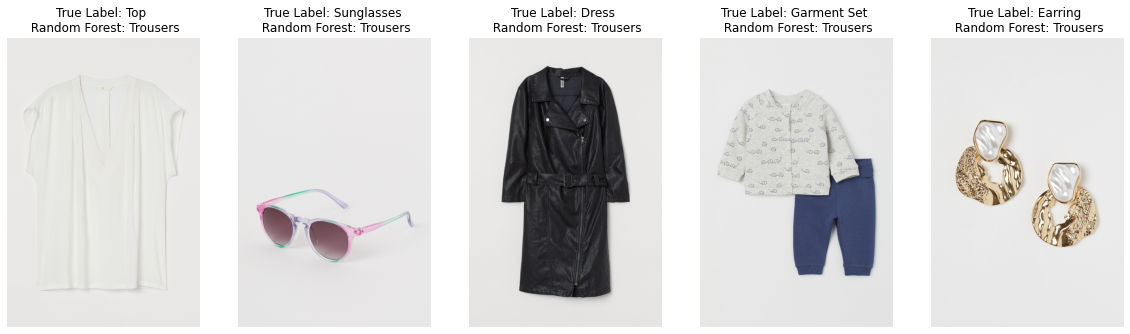

In [43]:
generate_caption()

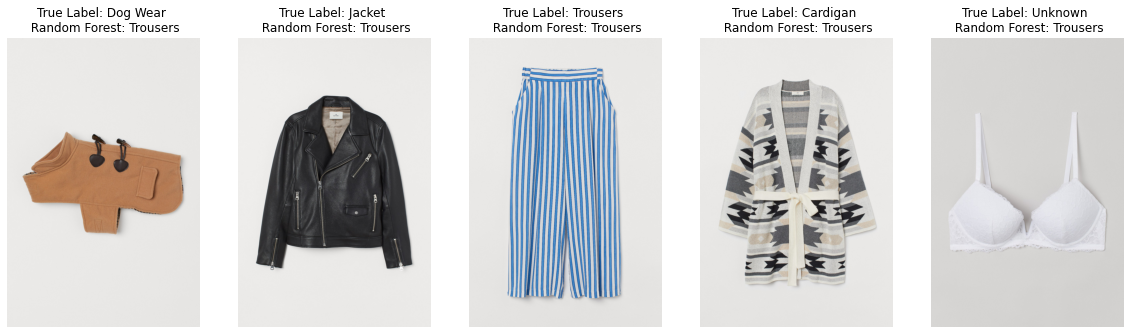

In [44]:
generate_caption()

In [45]:
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
!mkdir images

def plot_items(items):
    path = "../input/h-and-m-personalized-fashion-recommendations/images"

    k = len(items)
    for item, i in zip(items, range(1, k+1)):
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = Image.open(image)
       
        basewidth = 360
        wpercent = (basewidth / float(image.size[0]))
        hsize = int((float(image.size[1]) * float(wpercent)))
        image = image.resize((basewidth, hsize), Image.ANTIALIAS)
        image.save("./images/{}.jpeg".format(item[1:]))

mkdir: cannot create directory ‘images’: File exists


In [46]:
plot_items(sample_y.index.values)

In [47]:
model.model.save('model.h5')

In [48]:
sample_y.to_csv('product_tagging.csv')